In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from types import SimpleNamespace
import os
from PIL import UnidentifiedImageError
from torchsummary import summary

d:\dev\python\python3.11.4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameter
BATCH_SIZE = 16                         # Number of images in each batch, affects training speed and memory usage
EPOCHS = 20                             # Total training epochs (used for training loop control even if you don't train)
LR = 1e-3                               # Learning rate: controls parameter update step size
IMG_SIZE = 512                          # Input image size (images will be resized to 512×512)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Use GPU or CPU
SAVE_DIR = "ntc_output"                # Directory to save model weights and output images
os.makedirs(SAVE_DIR, exist_ok=True)   # Automatically create directory; avoid error if already exists


In [3]:
# Image preprocessing (Resize + ToTensor)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Resize all images to a consistent size
    transforms.ToTensor()                        # Convert to PyTorch Tensor, normalized to [0, 1]
])

# Batch transform with try/except (to skip broken images)
def transform_batch(batch):
    color_out, normal_out = [], []               # Initialize result lists

    # Iterate through paired images
    for color_img, normal_img in zip(batch["color"], batch["normal"]):
        try:
            # Try converting to RGB + preprocessing
            color_tensor = transform(color_img.convert("RGB"))
            normal_tensor = transform(normal_img.convert("RGB"))
        except Exception as e:
            print("⚠️ Skipping broken image:", e)  # Skip problematic images
            dummy = torch.zeros(3, IMG_SIZE, IMG_SIZE)  # Insert dummy tensor
            color_out.append(dummy)
            normal_out.append(dummy)
            continue

        # Append valid tensors
        color_out.append(color_tensor)
        normal_out.append(normal_tensor)

    return {"color": color_out, "normal": normal_out}

# Load dataset and set transform (no filter used anymore)
dataset = load_dataset("dream-textures/textures-color-normal-1k")["train"]   # Load training split
dataset.set_transform(transform_batch)  # Apply transform_batch to each batch

# Build dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# batch_size=16 means each batch contains 16 image pairs
# shuffle=True randomizes batch order each epoch


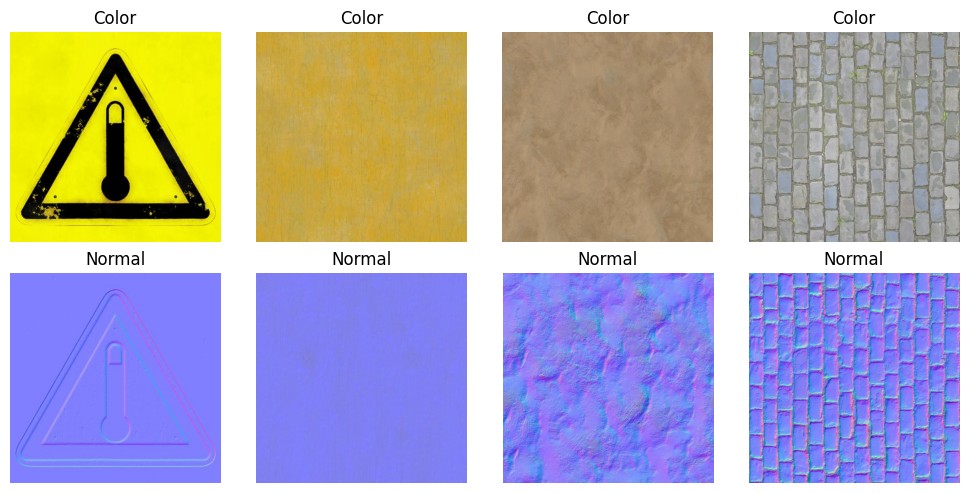

In [4]:
# Visualize some preprocessed images
import matplotlib.pyplot as plt

batch = next(iter(dataloader))
color_imgs = batch["color"]
normal_imgs = batch["normal"]

n = min(4, len(color_imgs))  # Show up to 4 image pairs
plt.figure(figsize=(10, 5))

for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(color_imgs[i].permute(1, 2, 0))  # C x H x W → H x W x C
    plt.title("Color")
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(normal_imgs[i].permute(1, 2, 0))
    plt.title("Normal")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
import torch.nn as nn

# 4. Define convolutional autoencoder model (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        # Encoder: compress input image to latent features (H/8 × W/8)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),   # Output: 256 → 128
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 128 → 64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 64 → 32
            nn.ReLU()
        )

        # Decoder: reconstruct original image from latent features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 32 → 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: 64 → 128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # Output: 128 → 256
            nn.Sigmoid()  # Normalize output to [0, 1] to match ToTensor range
        )

    # Forward pass (x → latent → x_reconstructed)
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize model (note: not training yet)
model = CAE().to(DEVICE)               # Move model to device (GPU/CPU)
print(f"Model initialized successfully. Using device: {DEVICE}")
criterion = nn.MSELoss()               # Loss function: Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # Optimizer: Adam


Model initialized successfully. Using device: cpu


In [6]:
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE), device=str(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
              ReLU-6          [-1, 128, 64, 64]               0
   ConvTranspose2d-7         [-1, 64, 128, 128]         131,136
              ReLU-8         [-1, 64, 128, 128]               0
   ConvTranspose2d-9         [-1, 32, 256, 256]          32,800
             ReLU-10         [-1, 32, 256, 256]               0
  ConvTranspose2d-11          [-1, 3, 512, 512]           1,539
          Sigmoid-12          [-1, 3, 512, 512]               0
Total params: 258,723
Trainable params: 258,723
Non-trainable params: 0
-------------------------------